**Flow path**:

NE -> NW
NW and SE -> SW
SW -> Murray Mouth

**Computing ΔQ**:

ΔQ_NE = Q_out

ΔQ_SE = Q_out

ΔQ_NW = Q_out - Q_NE

ΔQ_SW = Q_out - Q_NW - Q_SE

**Stations**:

*Primary Stations* - used as primary source of runoff data

NE: Darling @ Warraweena

SE: Murray @ Boundary Bend

NW: Darling @ Burtundy (Main Branch); Darling Anabranch @ Tara Downs

SW: Murray Lock 1 @ Blanchetown

*Secondary Stations* - used to fill missing data in primary stations

NW: Darling @ Pooncarie (Main Branch); Darling Anabranch @ Bulpunga

SW: Murray @ Morgan

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt


from shapely.geometry import Point
import matplotlib.ticker as mticker

In [2]:
# import MDB and subregion boundaries 
MDB_shape = gpd.read_file('MDB_Regions/MDB_Whole.shp')
MDB_northeast_shape = gpd.read_file('MDB_Regions/MDB_Northeast_Region.shp')
MDB_northwest_shape = gpd.read_file('MDB_Regions/MDB_Northwest_Region.shp')
MDB_southeast_shape = gpd.read_file('MDB_Regions/MDB_Southeast_Region.shp')
MDB_southwest_shape = gpd.read_file('MDB_Regions/MDB_Southwest_Region.shp')
MDB_regions_combined = gpd.read_file("MDB_Regions/MDB_Regions_Combined.shp")

In [3]:
rivers_MDB = gpd.read_file('Runoff/River-water-course-lines/river-water-course-lines_mdb_clipped.shp')

In [4]:
MDB_stations = pd.read_csv("Runoff/BOM_MDB_Stations.csv")

In [5]:
rivers_MDB = rivers_MDB.to_crs(MDB_shape.crs)

In [6]:
geometry = [Point(xy) for xy in zip(MDB_stations["Longitude"], MDB_stations["Latitude"])]
MDB_stations_gdf = gpd.GeoDataFrame(MDB_stations, geometry=geometry)
MDB_stations_gdf.set_crs(epsg=4326, inplace=True)
MDB_stations_gdf = MDB_stations_gdf.to_crs(MDB_shape.crs)

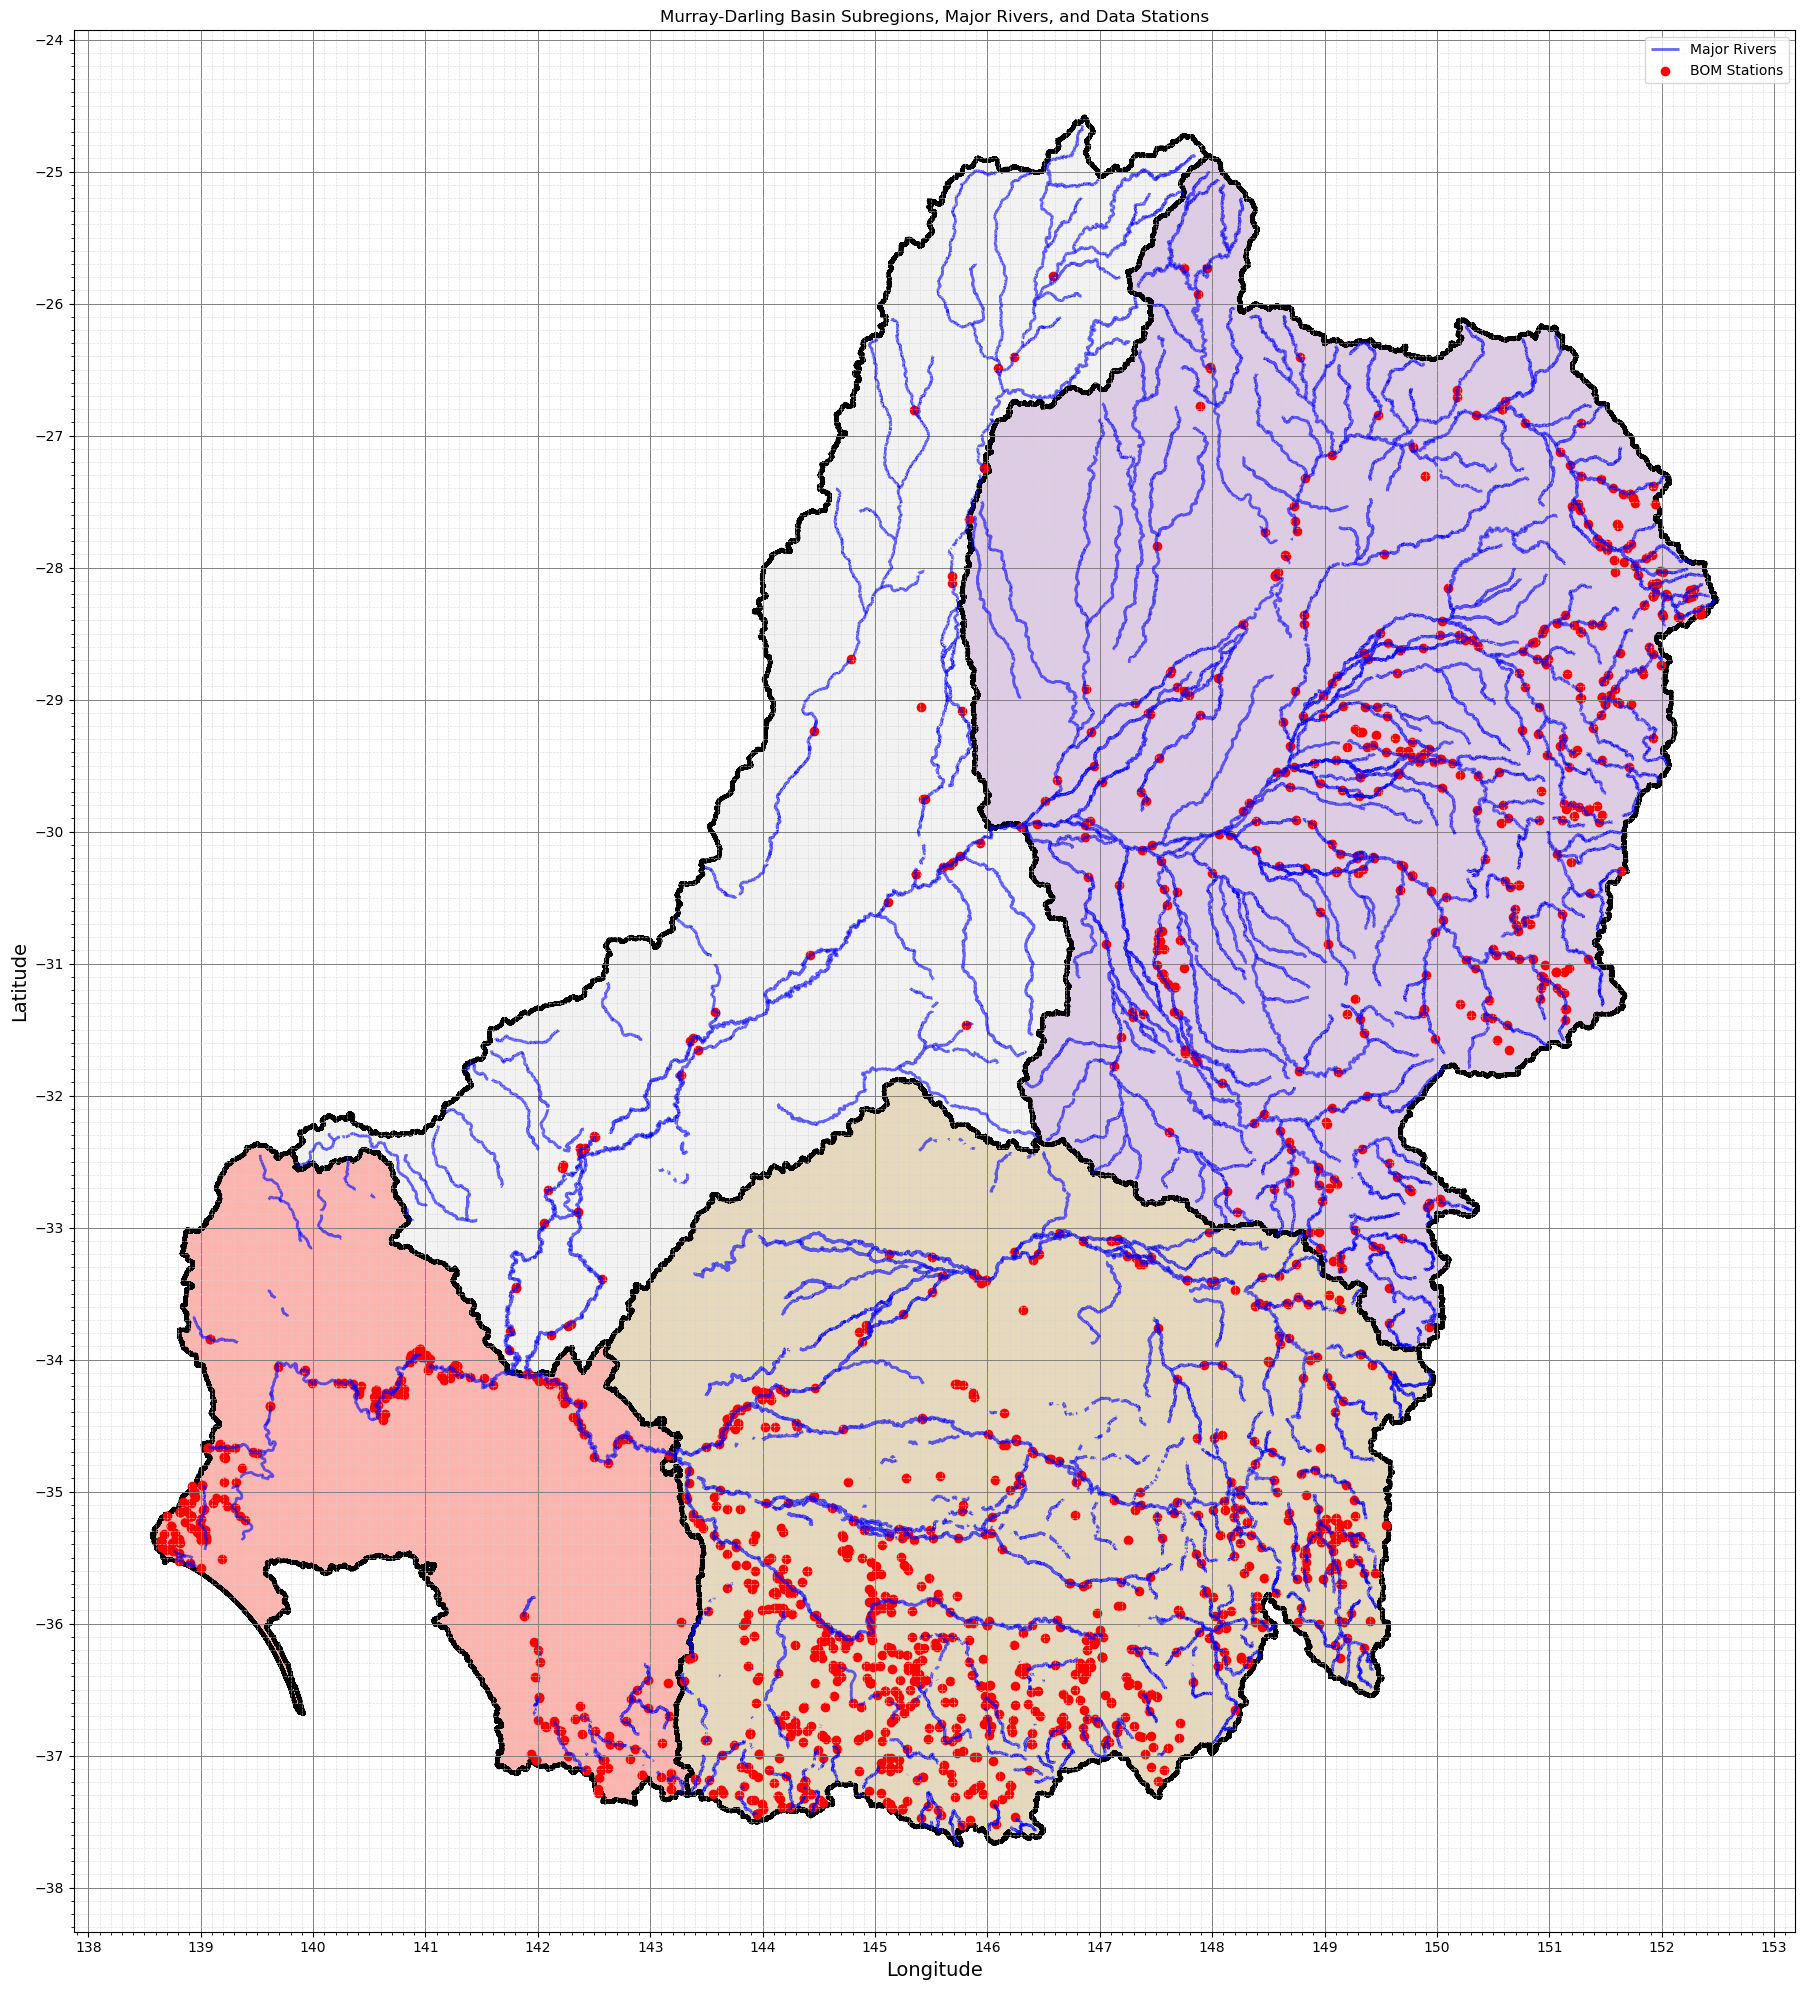

In [7]:
fig, ax = plt.subplots(figsize=(30, 20))
MDB_regions_combined.plot(ax=ax, column='rivregname', cmap="Pastel1", edgecolor='black', linewidth=3)
rivers_MDB.plot(ax=ax, color='blue', linewidth=2, alpha=0.6, label="Major Rivers")
MDB_stations_gdf.plot(ax=ax, color='red', markersize=30, linewidth=1.5, label="BOM Stations")

ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.1))

ax.grid(which='major', color='gray', linestyle='-', linewidth=0.7)
ax.grid(which='minor', color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)

ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.set_title("Murray-Darling Basin Subregions, Major Rivers, and Data Stations")

ax.legend()

plt.tight_layout()
plt.savefig("Runoff/Images/Image1(New).png")

plt.show()

In [8]:
MDB_Area = MDB_regions_combined.to_crs(epsg=3577)
MDB_Area["Area"] = MDB_Area.geometry.area
MDB_Area

,hydroid,division,rivregname,srcfcname,srcftype,srctype,sourceid,featrel,fsource,attrrel,...,planacc,symbol,textnote,globalid,rivregnum,albersarea,region,subregion,geometry,Area
0,43637147,Murray-Darling Basin,BORDER RIVERS,NaN,NaN,0,0,2019-08-21,Bureau of Meteorology,2019-08-21,...,15,0,NaN,f1bde64d-a082-44c9-89de-3f290993250c,17,4.862584e+10,North,North East,"MULTIPOLYGON (((1594809.640 -3765147.843, 1594...",3.902167e+11
1,43637152,Murray-Darling Basin,WARREGO RIVER,NaN,NaN,0,0,2019-08-21,Bureau of Meteorology,2019-08-21,...,15,0,NaN,9abead7e-ecb6-4bef-be4f-d6838b0167aa,24,5.628429e+10,North,North West,"MULTIPOLYGON (((946157.859 -3741169.395, 94613...",2.499370e+11
2,43637136,Murray-Darling Basin,UPPER MURRAY RIVER,NaN,NaN,0,0,2019-08-21,Bureau of Meteorology,2019-08-21,...,15,0,NaN,6f71368f-e37a-42ad-b00a-b67b50ab0693,1,1.533339e+10,South,South East,"MULTIPOLYGON (((1126290.173 -4123293.433, 1126...",2.889462e+11
3,43637157,Murray-Darling Basin,AVON RIVER-TYRELL LAKE,NaN,NaN,0,0,2019-08-21,Bureau of Meteorology,2019-08-21,...,15,0,NaN,a86a1dc4-3d3e-4569-ae47-238b6cbc1c80,9,1.215093e+10,South,South West,"MULTIPOLYGON (((701212.528 -4000742.284, 70123...",1.330183e+11


In [9]:
df = pd.read_csv('Runoff/Runoff Processing/Runoff_Inputs.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [10]:
def agg_df(df, column):
    start_date = pd.Timestamp(year=df['Date'].min().year,
                          month=df['Date'].min().month,
                          day=16)
    end_date = df['Date'].max()
    results = []
    while start_date + pd.DateOffset(days=30) <= end_date:
        period_start = start_date
        next_month = (start_date + pd.DateOffset(months=1))
        period_end = pd.Timestamp(year=next_month.year, month=next_month.month, day=15)
        mask = (df['Date'] >= period_start) & (df['Date'] <= period_end)
        period_sum = df.loc[mask, column].sum()
        results.append({column: period_sum})
        start_date = start_date + pd.DateOffset(months=1)
    agg_df = pd.DataFrame(results)
    return agg_df

In [11]:
NE = agg_df(df, "NE")
NW = agg_df(df, "NW")
SE = agg_df(df, "SE")
SW = agg_df(df, "SW")
dates = pd.date_range(start="2002-05-15", end="2024-04-15", freq="MS") + pd.offsets.Day(14)

In [12]:
monthly_runoff = pd.concat([NE, NW, SE, SW], axis=1)
monthly_runoff.index = dates

In [13]:
runoff_df = pd.DataFrame(index=dates)

In [14]:
runoff_df["NE"]=monthly_runoff["NE"]/MDB_Area["Area"][0]*1000
runoff_df["NW"]=(monthly_runoff["NW"]-monthly_runoff["NE"])/MDB_Area["Area"][1]*1000
runoff_df["SE"]=monthly_runoff["SE"]/MDB_Area["Area"][2]*1000
runoff_df["SW"]=(monthly_runoff["SW"]-monthly_runoff["NW"]-monthly_runoff["SE"])/MDB_Area["Area"][3]*1000
runoff_df["MDB"]=monthly_runoff["SW"]/sum(MDB_Area["Area"])*1000

In [15]:
runoff_df

,NE,NW,SE,SW,MDB
2002-06-15,1.495307e-05,-0.000003,0.000269,0.001049,0.000209
2002-07-15,9.923839e-06,0.000002,0.000260,0.000609,0.000151
2002-08-15,8.705833e-06,-0.000001,0.000328,0.000270,0.000126
2002-09-15,2.485242e-05,-0.000032,0.000300,0.000416,0.000135
2002-10-15,5.490971e-07,0.000010,0.000329,0.001519,0.000282
...,...,...,...,...,...
2023-12-15,9.936017e-05,0.000027,0.002149,-0.000705,0.000539
2024-01-15,1.086051e-04,-0.000028,0.000752,0.001221,0.000391
2024-02-15,8.223656e-05,-0.000017,0.001570,0.001547,0.000647
2024-03-15,6.681830e-05,0.000349,0.000667,-0.000810,0.000187


In [16]:
runoff_df.to_csv('Runoff/MDB_runoff.csv', index=True, date_format='%Y-%m-%d')

In [17]:
runoff_df

,NE,NW,SE,SW,MDB
2002-06-15,1.495307e-05,-0.000003,0.000269,0.001049,0.000209
2002-07-15,9.923839e-06,0.000002,0.000260,0.000609,0.000151
2002-08-15,8.705833e-06,-0.000001,0.000328,0.000270,0.000126
2002-09-15,2.485242e-05,-0.000032,0.000300,0.000416,0.000135
2002-10-15,5.490971e-07,0.000010,0.000329,0.001519,0.000282
...,...,...,...,...,...
2023-12-15,9.936017e-05,0.000027,0.002149,-0.000705,0.000539
2024-01-15,1.086051e-04,-0.000028,0.000752,0.001221,0.000391
2024-02-15,8.223656e-05,-0.000017,0.001570,0.001547,0.000647
2024-03-15,6.681830e-05,0.000349,0.000667,-0.000810,0.000187


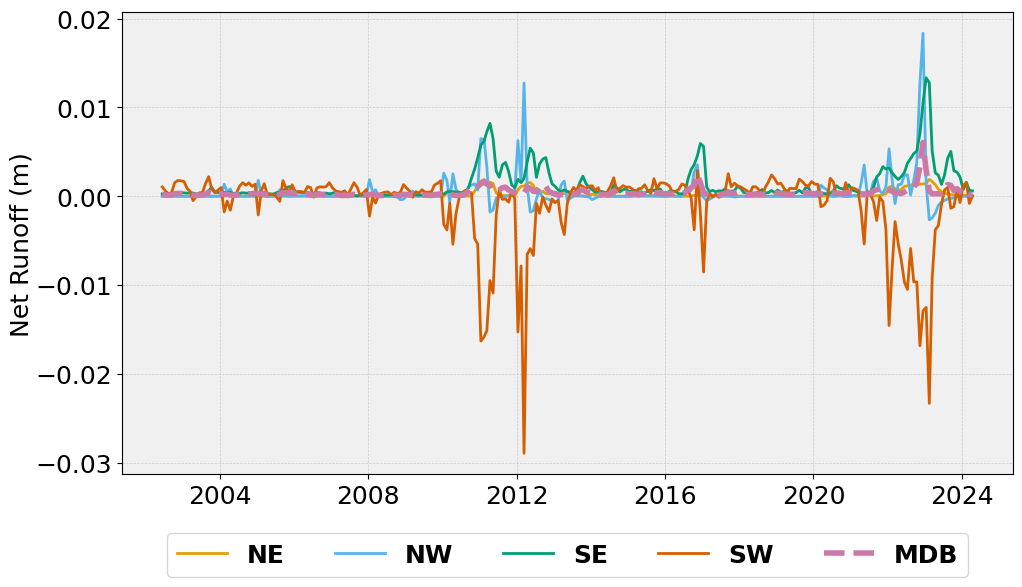

In [18]:
plt.figure(figsize=(11.5, 6))
colors = ['#E69F00', '#56B4E9', '#009E73', '#D55E00', '#CC79A7']
for i, column in enumerate(runoff_df.columns):
    if i == 4:
        plt.plot(runoff_df.index, runoff_df[column], label=column, color=colors[i], linewidth=4, linestyle='--')
    else:
        plt.plot(runoff_df.index, runoff_df[column], label=column, color=colors[i], linewidth=2)

ax = plt.gca()
ax.set_facecolor('#f0f0f0')
#plt.xlabel('Time')
plt.ylabel('Net Runoff (m)', fontsize=18, labelpad=1)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend(ncol=5,
           frameon=True, prop={'weight': 'bold', 'size' : 18}, 
           loc='upper center', bbox_to_anchor=(0.5, -0.1))
plt.savefig("Poster/Runoff.png", dpi=450,bbox_inches='tight')
plt.show()

In [19]:
selected_stations = MDB_stations_gdf[MDB_stations_gdf['Station_ID_New'].isin([648, 628, 654, 949, 1487, 631, 627, 967])]

In [20]:
selected_stations["Station_Name"] = ["Darling @ Pooncarie", "Darling @ Burtundy", "Darling Anabranch @ Bulpunga", "Darling @ Warraweena", "Darling Anabranch @ Tarra Downs", "Murray Lock 1 @ Blanchetown", "Murray @ Morgan", "Murray @ Boundary Bend"]
selected_stations["Station_Type"] = ["Secondary", "Primary", "Secondary", "Primary", "Primary", "Primary", "Secondary", "Primary"]

C:\Users\arfaa\anaconda3\envs\spanalytics\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\arfaa\anaconda3\envs\spanalytics\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [21]:
selected_stations.to_file("Runoff/Selected Stations/Selected Stations.shp")

C:\Users\arfaa\AppData\Local\Temp\ipykernel_36492\1347576379.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  selected_stations.to_file("Runoff/Selected Stations/Selected Stations.shp")
